In [ ]:
from argparse import Namespace
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import sys
import tqdm
import torch
import torch.nn.functional as F


sys.path.append('group_calibration')

from group_calibration.methods.group_calibration import calibrate_combine
from group_calibration.methods.temp_scaling import calibrate as ts_calibrate
from group_calibration.methods.mix_calibration import calibrate as ets_calibrate

sys.path.append("src")

from fm_calibration.calibration import *
from fm_calibration.metrics import *

## Load embeddings

### Tab-PFN

In [ ]:
datasets = []
train_data, val_data, test_data = [], [], []
with open('tabPFN/train_embeddings.json', 'r') as f:
    train_dict = json.load(f)
    train_dict = {k: torch.tensor(v).float().numpy() for k, v in train_dict.items()}
with open('tabPFN/val_embeddings.json', 'r') as f:
    val_dict = json.load(f)
    val_dict = {k: torch.tensor(v).float().numpy() for k, v in val_dict.items()}
with open('tabPFN/test_embeddings.json', 'r') as f:
    test_dict = json.load(f)
    test_dict = {k: torch.tensor(v).float().numpy() for k, v in test_dict.items()}
with open('tabPFN/train_labels.json', 'r') as f:
    train_labels = json.load(f)
    train_labels = {k: torch.tensor(v).long().numpy() for k, v in train_labels.items()}
with open('tabPFN/val_labels.json', 'r') as f:
    val_labels = json.load(f)
    val_labels = {k: torch.tensor(v).long().numpy() for k, v in val_labels.items()}
with open('tabPFN/test_labels.json', 'r') as f:
    test_labels = json.load(f)
    test_labels = {k: torch.tensor(v).long().numpy() for k, v in test_labels.items()}

train_data += list(zip(train_dict.values(), train_labels.values()))
val_data += list(zip(val_dict.values(), val_labels.values()))
test_data += list(zip(test_dict.values(), test_labels.values()))
datasets += [k + '-TAB' for k in train_dict.keys()]

### Mantis, MOMENT, BERT, GPT

In [ ]:
with open('MOMENT_train_sets.json', 'r') as f:
    train_sets = json.load(f)
    train_sets = {k: (torch.tensor(v[0]).float(), torch.tensor(v[1]).long()) for k, v in train_sets.items()}
with open('MOMENT_test_sets.json', 'r') as f:
    test_sets = json.load(f)
    test_sets = {k: (torch.tensor(v[0]).float(), torch.tensor(v[1]).long()) for k, v in test_sets.items()}

datasets = []
train_data, val_data, test_data = [], [], []
for dataset in tqdm.tqdm(train_sets.keys()):
    x_train = np.concatenate([train_sets[dataset][0], test_sets[dataset][0]], axis=0)
    y_train = np.concatenate([train_sets[dataset][1], test_sets[dataset][1]], axis=0)

    try:
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.5, random_state=42, stratify=y_train)
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    except ValueError as e:
        print(f"Error splitting dataset {dataset}: {e}")
        continue

    train_data.append((x_train, y_train))
    val_data.append((x_val, y_val))
    test_data.append((x_test, y_test))
    datasets.append(dataset)


 46%|████▌     | 58/127 [00:00<00:00, 172.49it/s]

Error splitting dataset DiatomSizeReduction: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Error splitting dataset FiftyWords: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Error splitting dataset Fungi: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


100%|██████████| 127/127 [00:00<00:00, 207.31it/s]

Error splitting dataset Phoneme: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Error splitting dataset PigAirwayPressure: The test_size = 21 should be greater or equal to the number of classes = 52
Error splitting dataset PigArtPressure: The test_size = 21 should be greater or equal to the number of classes = 52
Error splitting dataset PigCVP: The test_size = 21 should be greater or equal to the number of classes = 52
Error splitting dataset Symbols: The test_size = 5 should be greater or equal to the number of classes = 6


### Synthetic data

In [1]:
# D = 16
# w_oracle = np.array([[1., -1.] if not d else [0., 0.] for d in range(D)])
# x, y, yp = get_data(
#     global_w=w_oracle, a_noise_decision=1, bias_decision=0,
#     d=D, n=3000, alpha=0.1, nb_classes=2, w_reg=1.0, std_groups=5, noise_decision=0.4, seed=np.random.randint(0, 10000), K=3, alpha_K=0.5, debias=False, return_p=True,
# )
# perm = np.random.permutation(len(x))
# x , y, yp = x[perm], y[perm], yp[perm]
# x_train, x_val, y_train, y_val = x[:700], x[700:1000], y[:700], y[700:1000]
# x_test, y_test = x[1000:], y[1000:]
# yp_train, yp_val, yp_test = yp[:700], yp[700:1000], yp[1000:]

# Classification task

In [79]:
[(I, datasets[I], len(train_data[I][0])) for I in range(len(train_data)) if len(train_data[I][0]) > 250]

[(1, 'Adiac', 312),
 (13, 'ChlorineConcentration', 373),
 (17, 'CricketX', 312),
 (18, 'CricketY', 312),
 (19, 'CricketZ', 312),
 (20, 'Crop', 5760),
 (21, 'DistalPhalanxOutlineAgeGroup', 320),
 (22, 'DistalPhalanxOutlineCorrect', 480),
 (23, 'DistalPhalanxTW', 320),
 (27, 'Earthquakes', 257),
 (29, 'ECG5000', 400),
 (31, 'ElectricDevices', 7140),
 (32, 'EOGHorizontalSignal', 289),
 (33, 'EOGVerticalSignal', 289),
 (34, 'EthanolLevel', 403),
 (35, 'FaceAll', 448),
 (39, 'FordA', 2880),
 (40, 'FordB', 2908),
 (53, 'HandOutlines', 800),
 (61, 'LargeKitchenAppliances', 300),
 (66, 'MedicalImages', 304),
 (67, 'MelbournePedestrian', 955),
 (68, 'MiddlePhalanxOutlineAgeGroup', 320),
 (69, 'MiddlePhalanxOutlineCorrect', 480),
 (70, 'MiddlePhalanxTW', 319),
 (71, 'MixedShapesRegularTrain', 400),
 (74, 'NonInvasiveFetalECGThorax1', 1440),
 (75, 'NonInvasiveFetalECGThorax2', 1440),
 (78, 'PhalangesOutlinesCorrect', 1440),
 (80, 'PLAID', 429),
 (83, 'ProximalPhalanxOutlineAgeGroup', 320),
 (84, 

### Task definition

In [ ]:
I = 23 # Dataset index
C = 2 # One vs Rest class

print(datasets[I])
x_train, y_train = train_data[I]
x_val, y_val = val_data[I]
x_test, y_test = test_data[I]

for c in np.unique(y_test):
    lreg = LogisticRegression(max_iter=1000, C=1e0, random_state=0).fit(x_train, 1 * (y_train == c))
    print(c, (y_test == c).sum(), lreg.score(x_test, 1 * (y_test == c)))

y_train = 1 * (y_train == C)
y_val = 1 * (y_val == C)
y_test = 1 * (y_test == C)

# yp = yp[:, C]
# yp_train = yp_train[:, C]
# yp_val = yp_val[:, C]
# yp_test = yp_test[:, C]

x = np.concatenate([x_train, x_val, x_test])
y = np.concatenate([y_train, y_val, y_test])


DistalPhalanxTW
0 29 0.9275
1 28 0.93
2 82 0.7975
3 30 0.925
4 18 0.955
5 213 0.9775
0.7975


### Fit model

In [ ]:
lreg = LogisticRegression(max_iter=1000, C=1e0, random_state=0).fit(x_train, y_train)
print(lreg.score(x_test, y_test))

# import PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

### Obtain inference results

In [ ]:
y_pred_train = lreg.predict_proba(x_train)
y_pred_val = lreg.predict_proba(x_val)
y_pred_test = lreg.predict_proba(x_test)

In [ ]:
u1 = lreg.coef_[0, :].copy()
u1 /= np.linalg.norm(u1)

### Various recalibration methods

In [ ]:
print(safeCE(y_pred_test, y_test))
print(mc_brier_score(y_pred_test, y_test))
print(ece(y_pred_test, y_test))

print('global')

t_prior = temperature_scaling_grid(y_pred_val, y_val)


y_prior_test = F.softmax(torch.log(torch.tensor(y_pred_test)) * t_prior, dim=1).numpy()
y_cal_prior = y_prior_test

y_cal_prior_val = F.softmax(torch.log(torch.tensor(y_pred_val)) * t_prior, dim=-1).numpy()
y_prior_val = y_cal_prior_val


print(safeCE(y_cal_prior, y_test))
print(mc_brier_score(y_cal_prior, y_test))
print(ece(y_cal_prior, y_test))

ets = ets_fitter(y_pred_val, y_val)
y_cal_test_1 = ets(y_pred_test)
print(safeCE(y_cal_test_1, y_test))
print(mc_brier_score(y_cal_test_1, y_test))
print(ece(y_cal_test_1, y_test))


print('clustered')

ct = ClusteredTemperature(nb_clusters=2, nb_ensembles=50, dim_frac=4)
ct.fit(x_val, y_pred_val, y_val, x_train, seed=0) #, loss=0, loss_center=np.log(t_prior))
temps, y_cal_test_2 = ct.predict(x_test, y_pred_test, return_t=True)
print(safeCE(y_cal_test_2, y_test))
print(mc_brier_score(y_cal_test_2, y_test))
print(ece(y_cal_test_2, y_test))

ct = ClusteredTemperature(nb_clusters=2, nb_ensembles=50, dim_frac=4)
ct.fit(x_val, y_pred_val, y_val, x_train, seed=0, calib_fn_fitter=ets_fitter)
_, y_cal_test_4 = ct.predict(x_test, y_pred_test, return_t=True)
print(safeCE(y_cal_test_4, y_test))
print(mc_brier_score(y_cal_test_4, y_test))
print(ece(y_cal_test_4, y_test))


# pt = LocalCalib(gamma=0.1, sigma=0.1, dim_reduce=32, n_bins=20)
# pt.fit(x_val, y_cal_prior_val[:,1:], y_val, x_train, seed=0)
# _, y_cal_test_4 = pt.predict(x_test, y_cal_prior[:,1:], return_t=True)
# y_cal_test_4 = np.clip(y_cal_test_4, 0, 1)
# y_cal_test_4 = np.concat([1-y_cal_test_4, y_cal_test_4], axis=1)
# print(safeCE(y_cal_test_4, y_test))
# print(mc_brier_score(y_cal_test_4, y_test))
# print(ece(y_cal_test_4, y_test))

print('Semantic-aware groupings')
N_val = len(x_val)

res = calibrate_combine(
    torch.tensor(x_val[:N_val//4]).float(), torch.tensor(np.log(y_pred_val[:N_val//4])).float(), torch.tensor(y_val[:N_val//4]),
    torch.tensor(x_val[N_val//4:]).float(), torch.tensor(np.log(y_pred_val[N_val//4:])).float(), torch.tensor(y_val[N_val//4:]),
    torch.tensor(x_test).float(), torch.tensor(np.log(y_pred_test)).float(), Namespace(
        w_net=Namespace(model='linear', weight_decay=0.1),
        optimizer=Namespace(name='lbfgs', steps=100, lr=1e-3),
        num_partitions=20,
        num_groups=2,
        base_calibrator=Namespace(name='temp_scaling')
    ),
    ts_calibrate, 0, None,
)

y_cal_test_5 = res['prob'].numpy()
print(safeCE(y_cal_test_5, y_test))
print(mc_brier_score(y_cal_test_5, y_test))
print(ece(y_cal_test_5, y_test))

res = calibrate_combine(
    torch.tensor(x_val[:N_val//4]).float(), torch.tensor(np.log(y_pred_val[:N_val//4])).float(), torch.tensor(y_val[:N_val//4]),
    torch.tensor(x_val[N_val//4:]).float(), torch.tensor(np.log(y_pred_val[N_val//4:])).float(), torch.tensor(y_val[N_val//4:]),
    torch.tensor(x_test).float(), torch.tensor(np.log(y_pred_test)).float(), Namespace(
        w_net=Namespace(model='linear', weight_decay=0.1),
        optimizer=Namespace(name='lbfgs', steps=100, lr=1e-3),
        num_partitions=20,
        num_groups=2,
        base_calibrator=Namespace(name='ets')
    ),
    ets_calibrate, 0, None,
)

y_cal_test_6 = res['prob'].numpy()
print(safeCE(y_cal_test_6, y_test))
print(mc_brier_score(y_cal_test_6, y_test))
print(ece(y_cal_test_6, y_test))

0.30553207137854466
0.10068746014242208
0.07962801747396261
global
0.29066173482676816
0.10111158409300149
0.06754275067324374
0.3083874583244324
0.10090940344138245
0.07875642240047454
CT
0.35176959106534667
0.11222697402993384
0.12696441324738267
0.35658367879720304
0.11325786526600458
0.1342360395372972
>>>>> 80
Generating partitions...


100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Calibrating with partitions...


100%|██████████| 20/20 [00:00<00:00, 31.15it/s]


0.2832413613796234
0.09890131545473896
0.046950673013925553
Generating partitions...


100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Calibrating with partitions...


  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\m84398115\AppData\Local\miniconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\m84398115\AppData\Local\miniconda3\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 20/20 [00:00<00:00, 128.28it/s]

0.29102200269699097
0.09887907427492575
0.04686398506164552


### Compute "pseudo" local temperatures

In [530]:
Ts = np.logspace(-2, 2, 2001)
temps = Ts[((torch.softmax(torch.Tensor(np.log(y_pred_test)[None,:,:] / Ts[:,None,None]),-1) - y_pred_test) ** 2).sum(axis=2).argmin(axis=0)]

C:\Users\m84398115\AppData\Local\Temp\ipykernel_24572\4021887574.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  temps = Ts[((torch.softmax(torch.Tensor(np.log(y_pred_test)[None,:,:] / Ts[:,None,None]),-1) - y_pred_test) ** 2).sum(axis=2).argmin(axis=0)]


In [531]:
Ts = np.logspace(-2, 2, 5001)
temps_CE = torch.concatenate([
    torch.nn.functional.cross_entropy(torch.Tensor(np.log(y_cal_test_5) / Ts[i,None,None]), torch.Tensor(y_pred_test), reduction='none')[None, :]
    for i in range(len(Ts))
])
temps = Ts[temps_CE.argmin(axis=0)]

### Plot probability scores remappings

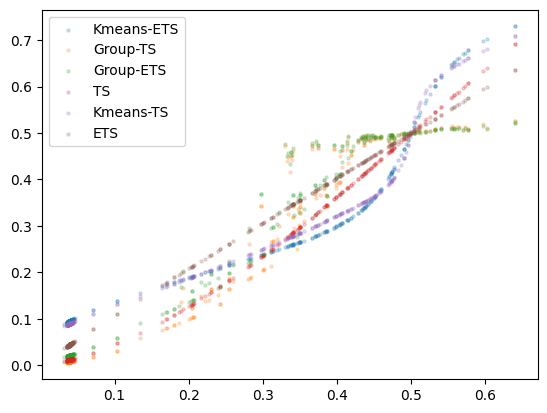

In [532]:
plt.scatter(
    y_pred_test[:,1],
    y_cal_test_4[:,1],
    s=5,
    alpha=0.2,
    label='Kmeans-ETS',
)
plt.scatter(
    y_pred_test[:,1],
    y_cal_test_5[:,1],
    s=5,
    alpha=0.2,
    label='Group-TS',
)
plt.scatter(
    y_pred_test[:,1],
    y_cal_test_6[:,1],
    s=5,
    alpha=0.2,
    label='Group-ETS',
)
plt.scatter(
    y_pred_test[:,1],
    y_cal_prior[:,1],
    s=5,
    alpha=0.2,
    label='TS',
)
plt.scatter(
    y_pred_test[:,1],
    y_cal_test_2[:,1],
    s=5,
    alpha=0.2,
    label='Kmeans-TS',
)
plt.scatter(
    y_pred_test[:,1],
    y_cal_test_1[:,1],
    s=5,
    alpha=0.2,
    label='ETS',
)
# plt.scatter(
#     y_pred_test[:,1],
#     yp_test,
#     s=5,
#     alpha=0.2,
#     color='black',
#     label='Raw',
# )
plt.legend()
plt.show()

### Plot local temperatures

In [536]:
from matplotlib import cm
from matplotlib.colors import to_rgb, ListedColormap
import colorsys
def lighten_color(rgb, amount=0.5, saturation_amount=0.5):
    """Lighten the RGB color by blending it with white."""
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s * saturation_amount)

# Generate a pastel version of the jet colormap
cmap = cm.get_cmap('turbo', 256)
pastel_colors = [lighten_color(to_rgb(cmap(i)[:3]), amount=0.1, saturation_amount=0.9) for i in range(256)]
pastel = ListedColormap(pastel_colors)

C:\Users\m84398115\AppData\Local\Temp\ipykernel_24572\81013328.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('turbo', 256)


In [537]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import colorsys

# Define HSL values and convert to RGB (matplotlib uses RGB)
# HSL: hue in [0,1], saturation and lightness in [0,1]
# We'll convert HSL to RGB using colorsys

# Define colors in HSL (Hue, Saturation, Lightness)
hsl_colors = [
    (350 / 360,   0.90, 0.40),   # Soft Red
    (0 / 360,   0.00, 0.80),  # Medium Grey
    (230 / 360, 0.90, 0.40),  # Soft Blue
]

# Convert HSL to RGB
rgb_colors = [colorsys.hls_to_rgb(h, l, s) for h, s, l in hsl_colors]

# Create colormap
cooldarkwarm = LinearSegmentedColormap.from_list("hsl_softcoolwarm", rgb_colors)


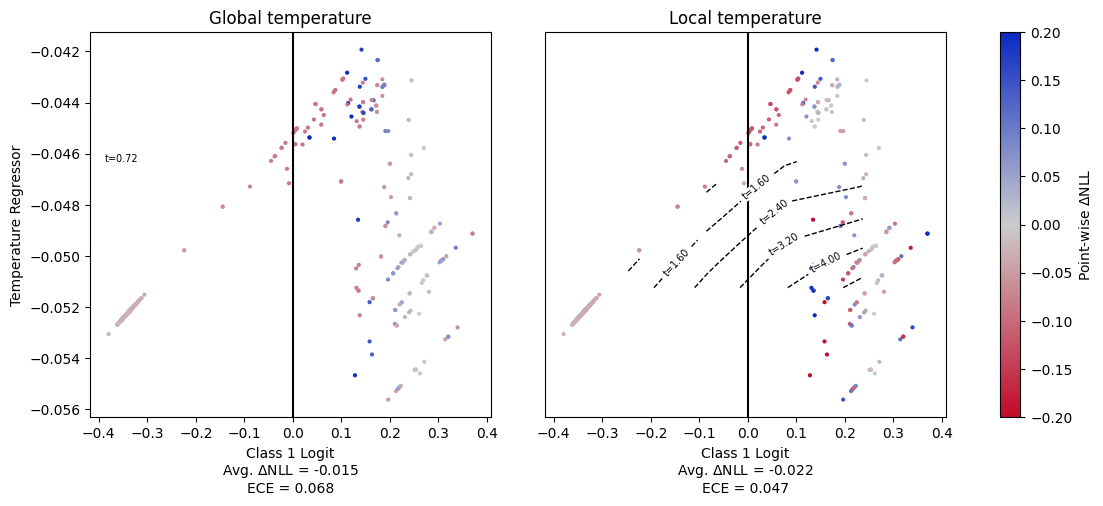

In [ ]:
v1 = u1
improv = np.log(temps)-np.log(t_prior)
temp_reg = LinearRegression().fit(x_test, improv)
v2 = temp_reg.coef_
v2 = v2 - v2.dot(v1) * v1
v2 /= np.linalg.norm(v2)
fig = plt.figure(figsize=(12, 5))

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.2, hspace=0.2)


delta = (
    ((np.log(y_prior_test) - np.log(y_pred_test)) * np.eye(y_cal_prior.shape[1])[
    y_test
    ]).sum(axis=1)
)

ax = fig.add_subplot(gs[0,0])
sc = ax.scatter(
    x_test.dot(v1), x_test.dot(v2),
    c=-delta,
    s=4, cmap=cooldarkwarm, vmin=-0.2, vmax=0.2)
ax.axvline(0, color='black')
ax.set_ylim(*y_lim)
ax.set_xlim(*x_lim)
ax.annotate(f't={1/t_prior:.2f}', (ax.get_xlim()[0]+0.03, ax.get_ylim()[0]+0.01), fontsize=7)
ax.set_title('Global temperature')
ax.set_xlabel(f'Class 1 Logit\nAvg. $\\Delta$NLL = {-delta.mean():.3f}\nECE = {ece(y_prior_test, y_test):.3f}')
ax.set_ylabel('Temperature Regressor')

delta = (
    ((np.log(y_cal_test_5) - np.log(y_pred_test)) * np.eye(y_cal_prior.shape[1])[
    y_test
    ]).sum(axis=1)
)

ax = fig.add_subplot(gs[0,1])
ax.scatter(
    x_test.dot(v1), x_test.dot(v2),
    c=-delta,
    s=4, cmap=cooldarkwarm, vmin=-0.2, vmax=0.2)
ax.axvline(0, color='black')
ax.set_title('Local temperature')
ax.set_ylim(*y_lim)
ax.set_xlim(*x_lim)
ax.set_xlabel(f'Class 1 Logit\nAvg. $\\Delta$NLL = {-delta.mean():.3f}\nECE = {ece(y_cal_test_5, y_test):.3f}')

# 2. Create a grid to interpolate onto
xi = np.linspace(x_lim[0]+0.01, x_lim[1]-0.01, 6)
yi = np.linspace(y_lim[0]+0.01, y_lim[1]-0.01, 6)
Xi, Yi = np.meshgrid(xi, yi)
from scipy.interpolate import griddata

# 3. Interpolate using griddata
Zi = griddata((x_test.dot(v1), x_test.dot(v2)), 1 / temps, (Xi, Yi), method='linear')  # method: 'linear', 'nearest', or 'cubic'

CS = ax.contour(Xi, Yi, Zi, linestyles='dashed', colors='black', linewidths=1, levels=5)
label_set = CS.clabel(fmt='t=%.2f', fontsize=7)
# Add white background to each label
for txt in label_set:

    txt.set_backgroundcolor('white')
    txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.2))
ax.set_yticks([])

cax = fig.add_subplot(gs[0,2])
fig.colorbar(sc, cax=cax, location='right', label='Point-wise $\\Delta$NLL')

plt.show()
fig.savefig('othertemps.pdf', bbox_inches='tight')

## Bonus : plot most informative true/predicted direction

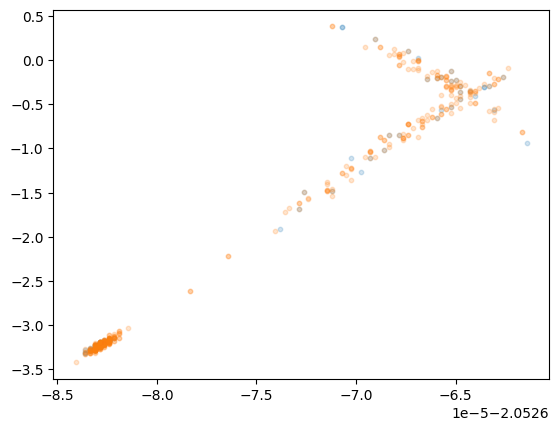

In [ ]:
lreg2 = Ridge(alpha=1e6).fit(x_val,
    np.log(-(np.log(y_pred_val) * np.eye(y_pred_val.shape[1])[y_val]).sum(axis=1))
)

plt.scatter(
    lreg2.predict(x_val),
    np.log(-(np.log(y_pred_val) * np.eye(y_pred_val.shape[1])[y_val]).sum(axis=1)),
    s=10, alpha=0.2,
)

plt.scatter(
    lreg2.predict(x_test),
    np.log(-(np.log(y_pred_test) * np.eye(y_pred_test.shape[1])[y_test]).sum(axis=1)),
    s=10, alpha=0.2,
)


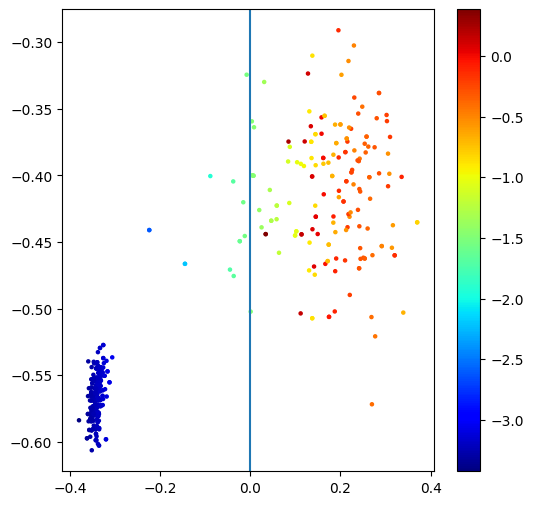

In [ ]:
h2 = lreg2.coef_.copy()
h2 = h2 - h2.dot(u1) * u1
h2 /= np.linalg.norm(h2)
plt.figure(figsize=(6, 6))
plt.scatter(x_test.dot(u1), x_test.dot(h2), c=np.log((
    -np.log(y_pred_test) * np.eye(y_pred_test.shape[1])[y_test]
).sum(axis=1)), s=5, cmap='jet')
plt.colorbar()
plt.axvline(0)
plt.show()

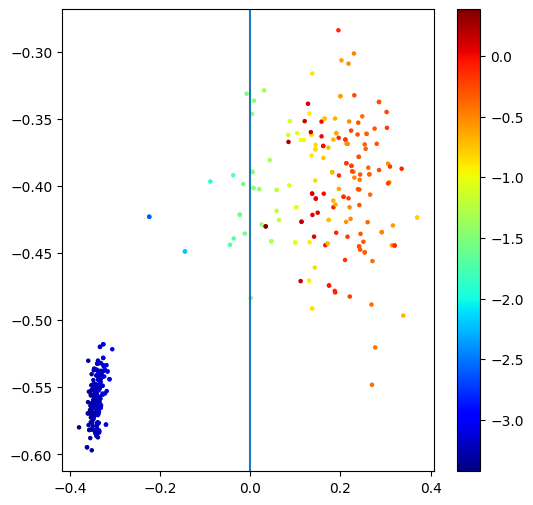

In [ ]:
lreg3 = Ridge(alpha=1e6).fit(x_test,
    np.log(-(np.log(y_pred_test) * np.eye(y_pred_test.shape[1])[y_test]).sum(axis=1))
)

hh2 = lreg3.coef_.copy()
hh2 = hh2 - hh2.dot(u1) * u1
hh2 /= np.linalg.norm(hh2)
plt.figure(figsize=(6, 6))
plt.scatter(x_test.dot(u1), x_test.dot(hh2), c=np.log((
    -np.log(y_pred_test) * np.eye(y_pred_test.shape[1])[y_test]
).sum(axis=1)), s=5, cmap='jet')
plt.colorbar()
plt.axvline(0)
plt.show()